In [1]:
import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument_drivers.NI.PXI_6251 import PXI_6251

import nidaqmx
from matplotlib import pyplot as plt
import numpy as np

import time

from lmfit import Model

In [2]:
%matplotlib notebook

In [3]:
daq = PXI_6251("daq")

In [4]:
station = qc.Station(daq)
qc.new_experiment(name='test_PXI_DAQ', sample_name='fiber181')

test_PXI_DAQ#fiber181#26@C:\Users\He5user/experiments.db
--------------------------------------------------------

In [5]:
sampling_rate_Hz = 333333
sampling_time_s = 2.5

In [6]:
daq.add_task("task")

daq.task.add_ai_channel('PDr','PXI-6251/ai0',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=1)
daq.task.add_ai_channel('PDt','PXI-6251/ai1',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=1)
daq.task.add_ai_channel('AWG','PXI-6251/ai2',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=2.1)

daq.task.add_sample_clock(333333, source='/PXI-6251/ai/SampleClockTimebase',
                            sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                            samps_per_chan=int(sampling_rate_Hz*sampling_time_s))

daq.task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.task.start_trigger.dig_edge_src.set('/PXI-6251/PFI0')

In [7]:
meas = Measurement()

In [8]:
daq.task.AIRead.prepare_AIRead()

In [9]:
meas.register_parameter(daq.task.AIRead, paramtype='array')

In [10]:
with meas.run() as datasaver:
    daq.task.start()

    while not daq.task._task.is_task_done():
        time.sleep(0.1)
        
    datasaver.add_result((daq.task.AIRead, daq.task.AIRead.get()))
    
    daq.task.stop()
    
    run_id = datasaver.run_id

Starting experimental run with id: 50


<IPython.core.display.Javascript object>


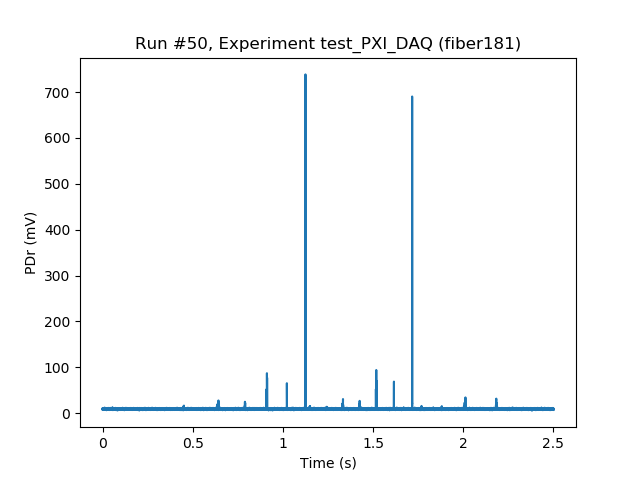

<IPython.core.display.Javascript object>


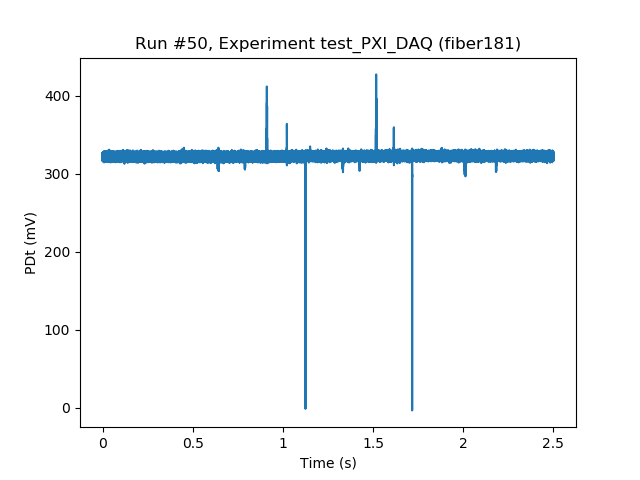

<IPython.core.display.Javascript object>


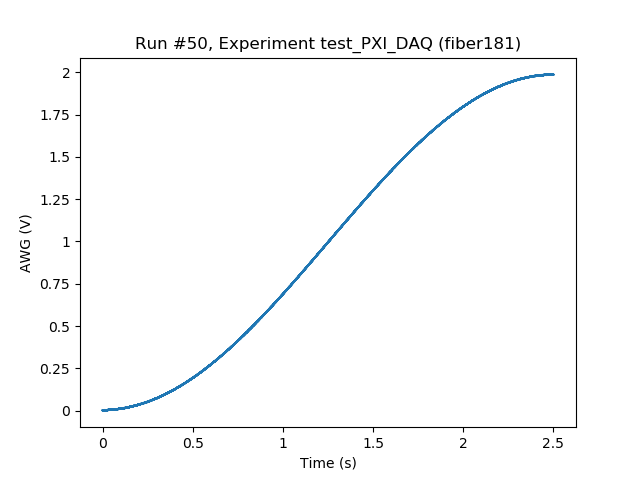

([<matplotlib.axes._subplots.AxesSubplot at 0x286e14a2fd0>,
 [None, None, None])

In [11]:
plot_by_id(datasaver.run_id)

In [12]:
daq.close()

{'freq': 0.1999733837228002, 'amp': 1.9840034689145216, 'offset': 0.9952329540493983, 't0': 1.2498094990988526}


<IPython.core.display.Javascript object>


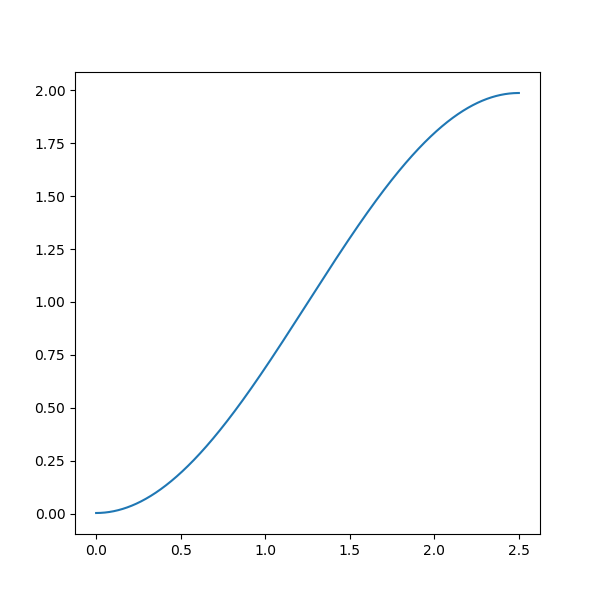

In [12]:
def sine(t, freq, amp, offset, t0):
    return offset + amp/2*np.sin((t-t0)*freq*2*np.pi)
gmodel = Model(sine)
result = gmodel.fit(c3, t=t, freq=0.2, amp=2, offset=1, t0=1.25)

print(result.best_values)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(result.best_fit, c3)
ax.plot(result.best_fit, c1)
ax.plot(result.best_fit, c2)